# ASAP processing

totalVI is an end-to-end framework for CITE-seq data. With totalVI, we can currently produce a joint latent representation of cells, denoised data for both protein and mRNA, and harmonize datasets. A test for differential expression of proteins is in the works. Here we demonstrate how to run totalVI on PBMC10k, a dataset of peripheral blood mononuclear cells publicly available from 10X Genomics with 17 proteins. We note that three proteins are control proteins so we remove them before running totalVI.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/master/tests/notebooks/totalVI.ipynb)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

show_plot = True


## Imports and data loading

In [22]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import anndata
import os

from scvi.dataset import Dataset10X
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')




In [23]:
dataset = Dataset10X(
    save_path="for_total_vi_asap_marrow2",
    measurement_names_column=1)

[2020-07-24 07:50:13,228] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2020-07-24 07:51:11,153] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2020-07-24 07:51:11,276] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2020-07-24 07:51:11,277] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-24 07:51:11,279] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-24 07:51:11,709] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-24 07:51:11,831] INFO - scvi.dataset.dataset | Downsampled from 10927 to 10927 cells


In [4]:
# Assume that the data has already been filtered before scVI gets it

To load from an AnnData object with `"protein_expression"` `obsm` and `"protein_names"` `uns`

```
from scvi.dataset import AnnDatasetFromAnnData, CellMeasurement

anndataset = anndata.read(save_path + "filename.h5ad")
dataset = AnnDatasetFromAnnData(ad=anndataset)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"],
)
dataset.initialize_cell_measurement(protein_data)
```

In general, protein data can be added to any `GeneExpressionDataset` through the `.initialize_cell_measurement(.)` method as shown above.

## Prepare and run model

In [27]:
totalvae = TOTALVI(dataset.nb_genes, len(dataset.protein_names))
use_cuda = True
lr = 4e-3
n_epochs = 500
# See early stopping documentation for explanation of parameters (trainer.py)
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
# Early stopping is done with respect to the test set
if True:
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }
else:
    early_stopping_kwargs = None
    
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [28]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2020-07-24 07:56:06,487] INFO - scvi.inference.inference | KL warmup for 8195.25 iterations


[2020-07-24 08:06:30,416] INFO - scvi.inference.trainer | Reducing LR on epoch 305.
[2020-07-24 08:09:38,163] INFO - scvi.inference.trainer | Reducing LR on epoch 397.
[2020-07-24 08:11:52,714] INFO - scvi.inference.trainer | Reducing LR on epoch 463.



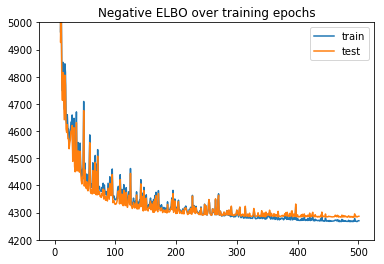

In [29]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(4200, 5000)
plt.legend()


## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI. The method `.sequential()` ensures that the ordering of outputs is the same as that in the dataset object.

In [30]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
full_posterior = full_posterior.update({"batch_size":32})

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
py_mixing = sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
)
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True
)

In [33]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=20, metric="correlation")
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=1)

In [43]:
sc.tl.umap(post_adata, min_dist=0.2)


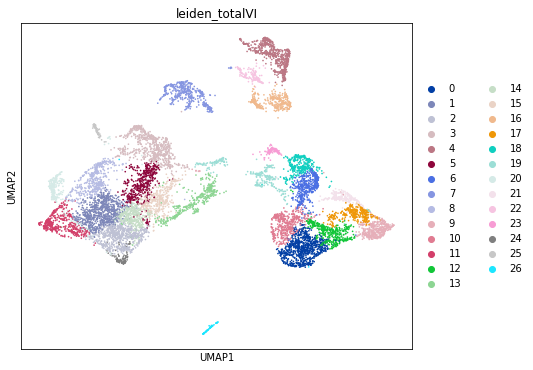

In [44]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI"], 
    ax=ax, 
    show=show_plot
)

In [41]:
parsed_protein_names

['CD80',
 'CD86',
 'CD274',
 'CD273',
 'CD275-1',
 'CD11b-1',
 'Galectin-9',
 'CD270',
 'CD252',
 'CD155(PVR)',
 'CD112(Nectin-2)',
 'CD47',
 'CD70',
 'CD30',
 'CD48',
 'CD40',
 'CD154',
 'CD52',
 'CD3-1',
 'CD4-1',
 'CD8',
 'CD56(NCAM)',
 'CD45-1',
 'CD3-2',
 'CD19',
 'CD11c',
 'CD34',
 'CD138-1(Syndecan-1)',
 'CD269(BCMA)',
 'CD90(Thy1)',
 'CD117(c-kit)',
 'CD45RA',
 'CD123',
 'CD105',
 'CD201',
 'CD194',
 'CD4-2',
 'CD44-1',
 'CD8a',
 'CD14',
 'CD16',
 'CD56(NCAM)Recombinant',
 'CD25',
 'CD45RO',
 'CD279',
 'TIGIT',
 'CD20',
 'CD335',
 'CD294',
 'CD31',
 'CD44-2',
 'CD133-1',
 'Podoplanin',
 'CD140a',
 'CD140b',
 'Cadherin11',
 'CD340',
 'CD146',
 'CD324',
 'IgM',
 'TCRgd',
 'CD195',
 'CD196',
 'CD185',
 'CD103',
 'CD69',
 'CD161',
 'CD152',
 'CD223',
 'CD27',
 'CD107a',
 'CD95',
 'CD134',
 'HLA-DR',
 'CD1c',
 'CD11b-2',
 'CD64',
 'CD141',
 'CD1d',
 'CD314',
 'CD66b',
 'CD35',
 'CD57-Recombinant',
 'CD366',
 'CD272',
 'CD278',
 'CD275-2',
 'CD96',
 'CD39',
 'CD178',
 'CX3CR1',
 'CD2

In [37]:
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i]

### Visualize denoised protein values 

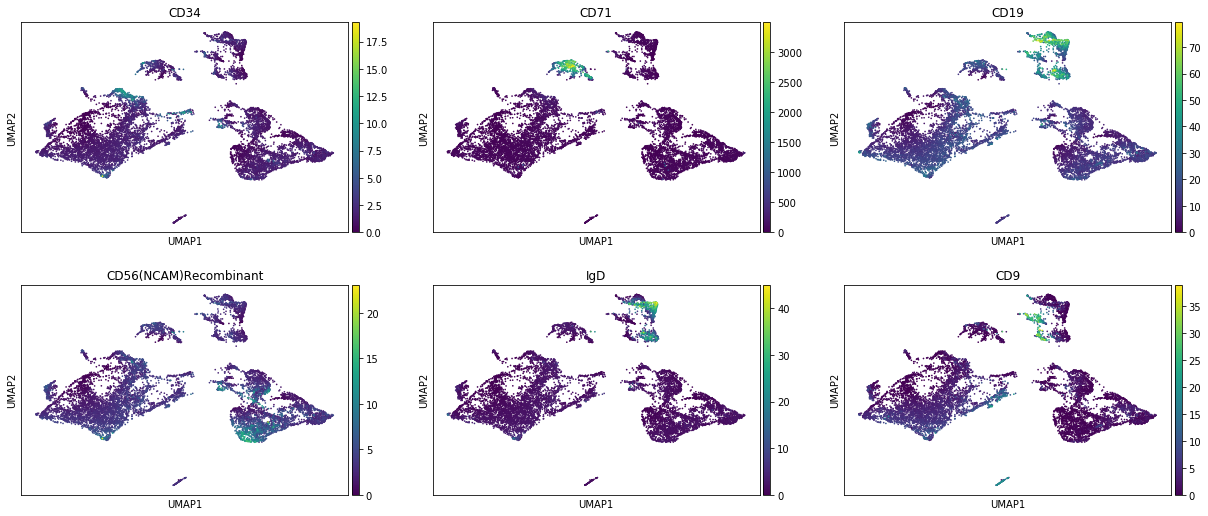

In [49]:
view_me = ["CD34", "CD71", "CD19", "CD56(NCAM)Recombinant", "IgD", "CD9"]
sc.pl.umap(
    post_adata, 
    color=view_me, 
    ncols=3, 
    show=show_plot
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see no localization in the monocytes.

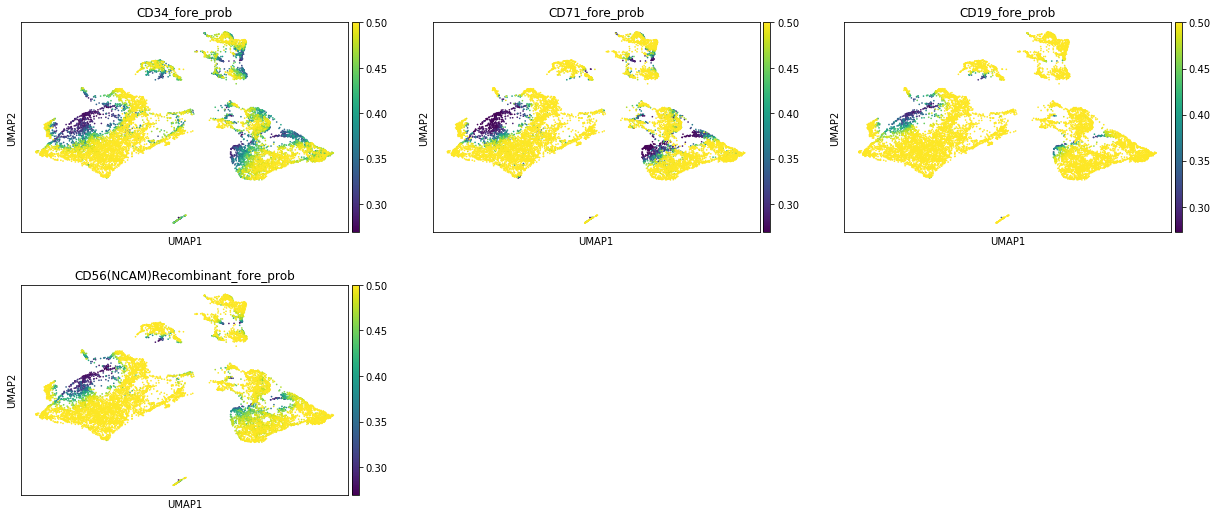

In [47]:
sc.pl.umap(
    post_adata,
    color=["{}_fore_prob".format(p) for p in view_me],
    ncols=3,
    show=show_plot,
)

In [50]:
# Gather all data to export

total_VI_dims = pd.DataFrame(post_adata.obsm["X_totalVI"], columns = ["scVI" + str(s) for s in range(1,21)], index = post_adata.obs.index)
umap_dims = pd.DataFrame(post_adata.obsm["X_umap"], columns = ["UMAP1", "UMAP2"], index = post_adata.obs.index)
barcode_df = pd.DataFrame(dataset.barcodes.tolist(), columns = ["barcode"], index = post_adata.obs.index)
full_df = pd.concat([barcode_df,umap_dims, total_VI_dims,post_adata.obs], axis=1)


In [51]:
full_df.to_csv('totalVI_output_bonemarrow_asap.csv')